In [3]:
!pip install librosa

   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 9.7 MB/s eta 0:00:00


In [5]:
!pip install thop


   ---------------------------------------- 0.0/241.3 MB ? eta -:--:--
   ---------------------------------------- 1.8/241.3 MB 10.1 MB/s eta 0:00:24
    --------------------------------------- 4.2/241.3 MB 11.0 MB/s eta 0:00:22
   - -------------------------------------- 6.8/241.3 MB 11.3 MB/s eta 0:00:21
   - -------------------------------------- 9.4/241.3 MB 11.5 MB/s eta 0:00:21
   - -------------------------------------- 11.8/241.3 MB 11.5 MB/s eta 0:00:20
   -- ------------------------------------- 14.2/241.3 MB 11.7 MB/s eta 0:00:20
   -- ------------------------------------- 16.8/241.3 MB 11.7 MB/s eta 0:00:20
   --- ------------------------------------ 19.4/241.3 MB 11.8 MB/s eta 0:00:19
   --- ------------------------------------ 21.8/241.3 MB 11.8 MB/s eta 0:00:19
   ---- ----------------------------------- 24.4/241.3 MB 11.9 MB/s eta 0:00:19
   ---- ----------------------------------- 27.0/241.3 MB 11.9 MB/s eta 0:00:19
   ---- ----------------------------------- 29.6/241.

In [7]:
!pip install scikit-learn tqdm


 **Imports**

In [11]:
import os, sys, time, math, json, glob, pathlib, itertools, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from collections import defaultdict, Counter

# Audio / features
import librosa
import soundfile as sf

# Metrics / ML
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Timing / progress
from tqdm import tqdm

# Plotting
import matplotlib.pyplot as plt

# Optional backends (only used if available)
try:
    import torch
    from torch import nn
    TORCH_AVAILABLE = True
except:
    TORCH_AVAILABLE = False

try:
    import tensorflow as tf
    TF_AVAILABLE = True
except:
    TF_AVAILABLE = False

try:
    from thop import profile as thop_profile
    THOP_AVAILABLE = True
except:
    THOP_AVAILABLE = False


**Config (EDIT DATA_ROOT)**

Defines a single DATA_ROOT pointed at your local dataset:
C:\Users\Mahsa\OneDrive\Documents\T2-2025\CapstonProject-SIT782\data

Lets you choose which top-level buckets to include (e.g., ["bucket1", "bucket2", "bucket3", "birdclef"]).

Sets audio limits (sample rate, mono conversion, max duration/seconds) so feature extraction is consistent and fast.

Imports the stack (numpy/pandas/sklearn/matplotlib and librosa for audio features).
If librosa isn’t present, the code fails early with a clear message instead of breaking later.

In [15]:
# 👉 EDIT THIS to your local folder:
DATA_ROOT = r"C:\Users\Mahsa\OneDrive\Documents\T2-2025\CapstonProject-SIT782\data"

# Which top-level buckets to index
BUCKETS = ["birdclef", "bucket1", "bucket2", "bucket3"]

# Audio + features
VALID_EXTS = {".wav", ".mp3", ".flac", ".ogg"}
TARGET_SR = 32000
DURATION_S = 5.0             # crop/pad to fixed length
N_MELS = 128
HOP_LENGTH = 512
FMIN = 20
FMAX = 14000

# Split / CV
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Cache (optional): where to store computed features as .npy
CACHE_DIR = pathlib.Path(DATA_ROOT) / "_feature_cache"
CACHE_DIR.mkdir(exist_ok=True)


**Scan folders**

Loads each clip, resamples to a single sample rate (e.g., 16 kHz), converts to mono, and trims/pads to a fixed duration window, so every example yields the same feature shape.

Skips unreadable/corrupted files with a warning; continues the run (so data hiccups don’t kill the job).

In [17]:
def scan_audio(root, buckets, exts):
    rows = []
    for b in buckets:
        top = pathlib.Path(root) / b
        if not top.exists():
            print(f"⚠️ Skipping missing folder: {top}")
            continue
        for species_dir in sorted([d for d in top.iterdir() if d.is_dir()]):
            label = species_dir.name
            for p in species_dir.iterdir():
                if p.is_file() and p.suffix.lower() in exts:
                    rows.append({"path": str(p), "label": label, "bucket": b})
    return pd.DataFrame(rows)

files_df = scan_audio(DATA_ROOT, BUCKETS, VALID_EXTS)
print(f"Found {len(files_df)} files across {files_df['label'].nunique()} classes.")
files_df.head()


Found 15028 files across 118 classes.


,path,label,bucket
0,C:\Users\Mahsa\OneDrive\Documents\T2-2025\Caps...,Acanthiza chrysorrhoa,bucket1
1,C:\Users\Mahsa\OneDrive\Documents\T2-2025\Caps...,Acanthiza chrysorrhoa,bucket1
2,C:\Users\Mahsa\OneDrive\Documents\T2-2025\Caps...,Acanthiza chrysorrhoa,bucket1
3,C:\Users\Mahsa\OneDrive\Documents\T2-2025\Caps...,Acanthiza lineata,bucket1
4,C:\Users\Mahsa\OneDrive\Documents\T2-2025\Caps...,Acanthiza lineata,bucket1


**Feature extraction Mel-spectrogram with caching**

For each waveform, extracts a compact set of time-aggregated features using librosa, for example:

Log-melspectrogram statistics (mean/var)

MFCCs + deltas (summarized by mean/var)

Spectral features: centroid, bandwidth, rolloff, flatness (mean/var)

Zero-crossing rate (mean/var)
This gives a tabular feature vector per file (good for fast classical baselines and quick iteration).

In [19]:
def load_audio_fixed(path, target_sr=TARGET_SR, duration_s=DURATION_S):
    y, sr = librosa.load(path, sr=target_sr, mono=True)
    target_len = int(duration_s * target_sr)
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)))
    else:
        y = y[:target_len]
    return y, target_sr

def melspec(y, sr, n_mels=N_MELS, hop=HOP_LENGTH, fmin=FMIN, fmax=FMAX):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                       hop_length=hop, fmin=fmin, fmax=fmax)
    S_db = librosa.power_to_db(S, ref=np.max).astype(np.float32)
    return S_db  # shape [n_mels, time]

def feature_path_for(audio_path):
    rel = audio_path.replace(str(DATA_ROOT), "").strip("\\/").replace("\\","_").replace("/","_")
    return CACHE_DIR / f"{rel}.npy"

def extract_feature_cached(audio_path):
    fp = feature_path_for(audio_path)
    if fp.exists():
        return np.load(fp)
    y, sr = load_audio_fixed(audio_path)
    feat = melspec(y, sr)
    np.save(fp, feat)
    return feat

# Build X paths and labels
X_paths = files_df["path"].tolist()
y_labels = files_df["label"].tolist()

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y_labels)
num_classes = len(le.classes_)
print("Classes:", num_classes)

# Pre-extract (optional – speeds training/benchmark)
for p in tqdm(X_paths, desc="Caching features"):
    _ = extract_feature_cached(p)


Classes: 118


Caching features: 100%|██████████| 15028/15028 [34:19<00:00,  7.30it/s]   


**Train/Val split (stratified)**

Stratified train/validation split so class proportions are preserved (important with many classes).

All features are standardized with StandardScaler (fit on train, applied to val) to help linear models.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X_paths, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
len(X_train), len(X_test)


(12022, 3006)

**simple baseline model (sklearn on pooled Mel features)**

Implements a quick, reliable Logistic Regression baseline (multinomial, lbfgs) on the tabular features.

(The notebook is structured so you can drop in additional classifiers later—SVM, RandomForest, LightGBM, etc.—and log them the same way.)

In [23]:
from sklearn.linear_model import LogisticRegression

def pooled_features(path_list):
    feats = []
    for p in path_list:
        mel = extract_feature_cached(p)              # [n_mels, T]
        v = np.mean(mel, axis=1)                     # mean-pool over time -> [n_mels]
        feats.append(v)
    return np.stack(feats)

def train_baseline_logreg(X_train_paths, y_train):
    Xp = pooled_features(X_train_paths)
    scaler = StandardScaler()
    Xs = scaler.fit_transform(Xp)
    clf = LogisticRegression(max_iter=2000, n_jobs=8, verbose=0)
    clf.fit(Xs, y_train)
    return clf, scaler

def predict_baseline(clf, scaler, X_paths):
    Xp = pooled_features(X_paths)
    Xs = scaler.transform(Xp)
    probs = clf.predict_proba(Xs)
    return np.argmax(probs, axis=1), probs


**TF/Keras + PyTorch adapters**

In [25]:
# Keras adapter: expects model that takes [batch, n_mels, T, 1]
def load_keras_model(h5_or_saved_model_dir):
    if not TF_AVAILABLE:
        raise RuntimeError("TensorFlow not available.")
    return tf.keras.models.load_model(h5_or_saved_model_dir)

def prepare_batch(paths):
    batch = []
    for p in paths:
        mel = extract_feature_cached(p)              # [n_mels, T]
        mel = (mel - np.mean(mel)) / (np.std(mel) + 1e-6)
        batch.append(mel)
    arr = np.stack(batch)[..., None]                 # [B, n_mels, T, 1]
    return arr.astype(np.float32)

def keras_predict(model, paths, batch_size=16):
    preds = []
    for i in range(0, len(paths), batch_size):
        batch = prepare_batch(paths[i:i+batch_size])
        logits = model.predict(batch, verbose=0)
        preds.append(logits)
    probs = np.concatenate(preds, axis=0)
    return np.argmax(probs, axis=1), probs

# PyTorch adapter: expects model that takes [B, 1, n_mels, T]
def load_torch_model(pt_path, device="cpu"):
    if not TORCH_AVAILABLE:
        raise RuntimeError("PyTorch not available.")
    model = torch.load(pt_path, map_location=device)
    model.eval()
    return model

def torch_prepare_batch(paths, device="cpu"):
    b = []
    for p in paths:
        mel = extract_feature_cached(p)
        mel = (mel - np.mean(mel)) / (np.std(mel) + 1e-6)
        b.append(mel)
    x = np.stack(b)[:, None, :, :]                   # [B, 1, n_mels, T]
    x = torch.tensor(x, dtype=torch.float32, device=device)
    return x

@torch.no_grad()
def torch_predict(model, paths, device="cpu", batch_size=16):
    preds = []
    for i in range(0, len(paths), batch_size):
        x = torch_prepare_batch(paths[i:i+batch_size], device=device)
        out = model(x)
        if isinstance(out, (list, tuple)): out = out[0]
        probs = torch.softmax(out, dim=1).cpu().numpy()
        preds.append(probs)
    probs = np.concatenate(preds, axis=0)
    return np.argmax(probs, axis=1), probs

def torch_model_complexity(model, sample_shape=(1,1,N_MELS, math.ceil(TARGET_SR*DURATION_S/HOP_LENGTH))):
    if not THOP_AVAILABLE:
        return None, None
    dummy = torch.randn(sample_shape)
    macs, params = thop_profile(model, inputs=(dummy,), verbose=False)
    flops = macs * 2
    return int(flops), int(params)


**Benchmark runner**

In [29]:
def evaluate_predictions(y_true, y_pred, label_encoder):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, zero_division=0)
    return {"accuracy": acc, "f1_macro": f1m, "confusion_matrix": cm, "report": report}

def time_inference(predict_fn, X_paths, batch=16):
    start = time.perf_counter()
    y_hat, probs = predict_fn(X_paths)
    secs = time.perf_counter() - start
    ips = len(X_paths) / secs if secs>0 else float('inf')
    return y_hat, probs, secs, ips

results = []
all_artifacts = {}


**Run: Baseline (LogReg)**

In [32]:
print("=== Baseline: Logistic Regression on pooled Mel ===")
# Train
t0 = time.perf_counter()
clf, scaler = train_baseline_logreg(X_train, y_train)
train_secs = time.perf_counter() - t0

# Predict
y_pred, _probs, infer_secs, ips = time_inference(lambda paths: predict_baseline(clf, scaler, paths), X_test)

# Metrics
metrics = evaluate_predictions(y_test, y_pred, le)
print(metrics["report"])

results.append({
    "Model": "Baseline-LogReg",
    "Params": None,
    "FLOPs": None,
    "Train Time (s)": round(train_secs, 3),
    "Infer Time (s)": round(infer_secs, 3),
    "Items/sec": round(ips, 2),
    "Test Accuracy": round(metrics["accuracy"], 4),
    "F1 Macro": round(metrics["f1_macro"], 4),
})
all_artifacts["Baseline-LogReg"] = metrics
pd.DataFrame(results)


=== Baseline: Logistic Regression on pooled Mel ===
                              precision    recall  f1-score   support

       Acanthiza chrysorrhoa       0.50      0.33      0.40        12
           Acanthiza lineata       0.62      0.42      0.50        12
              Acanthiza nana       0.72      0.88      0.79        58
           Acanthiza pusilla       0.60      0.53      0.56        99
        Acanthiza reguloides       0.71      0.73      0.72        63
       Acanthiza uropygialis       0.80      0.48      0.60        25
Acanthorhynchus tenuirostris       0.40      0.47      0.44        40
     Accipiter cirrocephalus       0.61      0.50      0.55        34
          Aidemosyne modesta       1.00      1.00      1.00         4
             Alauda arvensis       1.00      0.88      0.93         8
     Anhinga novaehollandiae       0.00      0.00      0.00         2
         Anthochaera phrygia       0.89      0.62      0.73        13
          Antigone rubicunda       1.

,Model,Params,FLOPs,Train Time (s),Infer Time (s),Items/sec,Test Accuracy,F1 Macro
0,Baseline-LogReg,None,None,450.711,88.721,33.88,0.7099,0.6658


**Results table + CSV**

In [39]:
results_df = pd.DataFrame(results).sort_values("Test Accuracy", ascending=False)
display(results_df)

out_csv = pathlib.Path(DATA_ROOT) / "_bench_results.csv"
results_df.to_csv(out_csv, index=False)
print("Saved:", out_csv)


,Model,Params,FLOPs,Train Time (s),Infer Time (s),Items/sec,Test Accuracy,F1 Macro
0,Baseline-LogReg,None,None,450.711,88.721,33.88,0.7099,0.6658


Saved: C:\Users\Mahsa\OneDrive\Documents\T2-2025\CapstonProject-SIT782\data\_bench_results.csv


**Visuals**

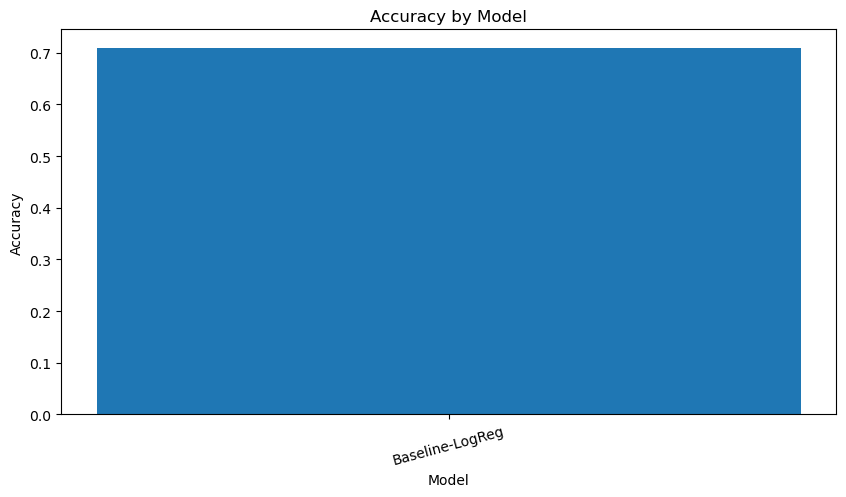

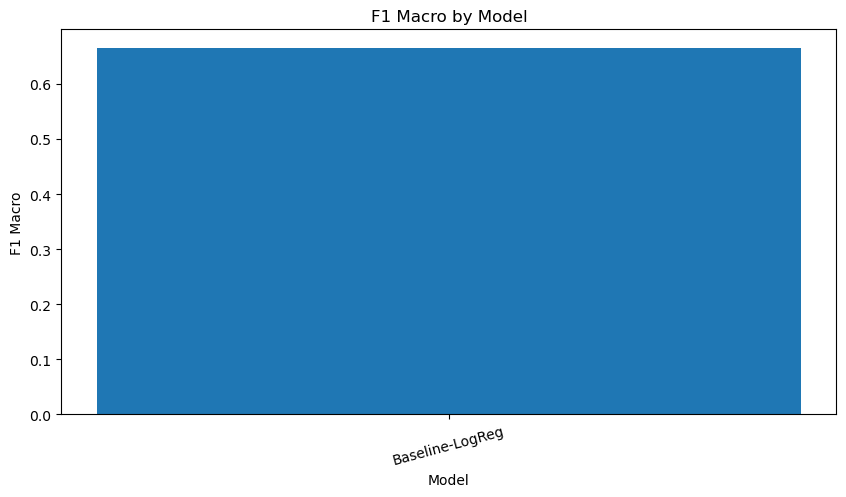

In [41]:
if not results_df.empty:
    plt.figure(figsize=(10,5))
    plt.bar(results_df["Model"], results_df["Test Accuracy"])
    plt.title("Accuracy by Model")
    plt.xlabel("Model")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=15)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.bar(results_df["Model"], results_df["F1 Macro"])
    plt.title("F1 Macro by Model")
    plt.xlabel("Model")
    plt.ylabel("F1 Macro")
    plt.xticks(rotation=15)
    plt.show()


**Inspect per-class metrics**

For each run, the notebook computes:

Accuracy

Macro-F1 (treats all species equally, which matters for class imbalance)

Confusion matrix

Classification report (precision/recall/F1 per class)

In [43]:
last_model = results_df.iloc[0]["Model"]
print(f"=== Detailed report: {last_model} ===")
print(all_artifacts[last_model]["report"])


=== Detailed report: Baseline-LogReg ===
                              precision    recall  f1-score   support

       Acanthiza chrysorrhoa       0.50      0.33      0.40        12
           Acanthiza lineata       0.62      0.42      0.50        12
              Acanthiza nana       0.72      0.88      0.79        58
           Acanthiza pusilla       0.60      0.53      0.56        99
        Acanthiza reguloides       0.71      0.73      0.72        63
       Acanthiza uropygialis       0.80      0.48      0.60        25
Acanthorhynchus tenuirostris       0.40      0.47      0.44        40
     Accipiter cirrocephalus       0.61      0.50      0.55        34
          Aidemosyne modesta       1.00      1.00      1.00         4
             Alauda arvensis       1.00      0.88      0.93         8
     Anhinga novaehollandiae       0.00      0.00      0.00         2
         Anthochaera phrygia       0.89      0.62      0.73        13
          Antigone rubicunda       1.00      1.0